**Initialize Data-Set**

In [23]:
import numpy as np
import csv
import matplotlib.pyplot as plt

#Import CSV file
DS_raw = open('parkinsons.data', mode='r')

#Read and convert to list of lists
DS_lines = list(csv.reader(DS_raw))

#Isolate row with column names
DS_columns = np.array(DS_lines[0])

DS_feat = {}
for i, feat in enumerate(DS_columns): DS_feat[feat] = i
#Convert values to float
for i in range(len(DS_lines)-1):
    for j in range(len(DS_lines[i])-1):
        try:
            DS_lines[i+1][j+1] = float(DS_lines[i+1][j+1])
        except ValueError:
            pass

DS = np.array(DS_lines[1:], dtype=object)

#Normalize Inputs to be between 0 and 1
for j in range(DS.shape[1]):
  if j != 0:
    DS[:,j] = (DS[:,j]-np.amin(DS[:,j])) / (np.amax(DS[:,j])-np.amin(DS[:,j]))

**Arrange data by status and patient**

{'Positive': [[Patient0 Samples], [Patient1 Samples], ...], 'Negative': [[Patient0 Samples], [Patient1 Samples], ...]}


[PatientX Samples] is a np.array

In [24]:
#Column index of response
status_idx = DS_feat['status']

#Create dictionary dividing healthy and sick patients
stt_pat_dict = {1: [], 0: []}
#Create list of indices of data points for each patient
#(Every patient has about 6 data points)
patients_ids = []

#Populate dicionary and list
prev_patient_ids = []
prev_patient = ''
i = -1
for row in DS:
  patient = row[0][:-2]
  prev_patient_ids.append(i)
  if patient != prev_patient:
    stt_pat_dict[row[status_idx]].append(row.reshape(1,-1))
    patients_ids.append(prev_patient_ids)
    prev_patient_ids = []
  else:
    stt_pat_dict[row[status_idx]][-1] = np.append(stt_pat_dict[row[status_idx]][-1], row.reshape(1,-1), axis = 0)
  prev_patient = patient
  i =i+1

prev_patient_ids.append(i)
patients_ids.append(prev_patient_ids)
patients_ids.pop(0)

[-1]

**Plot Correlation Matrix**

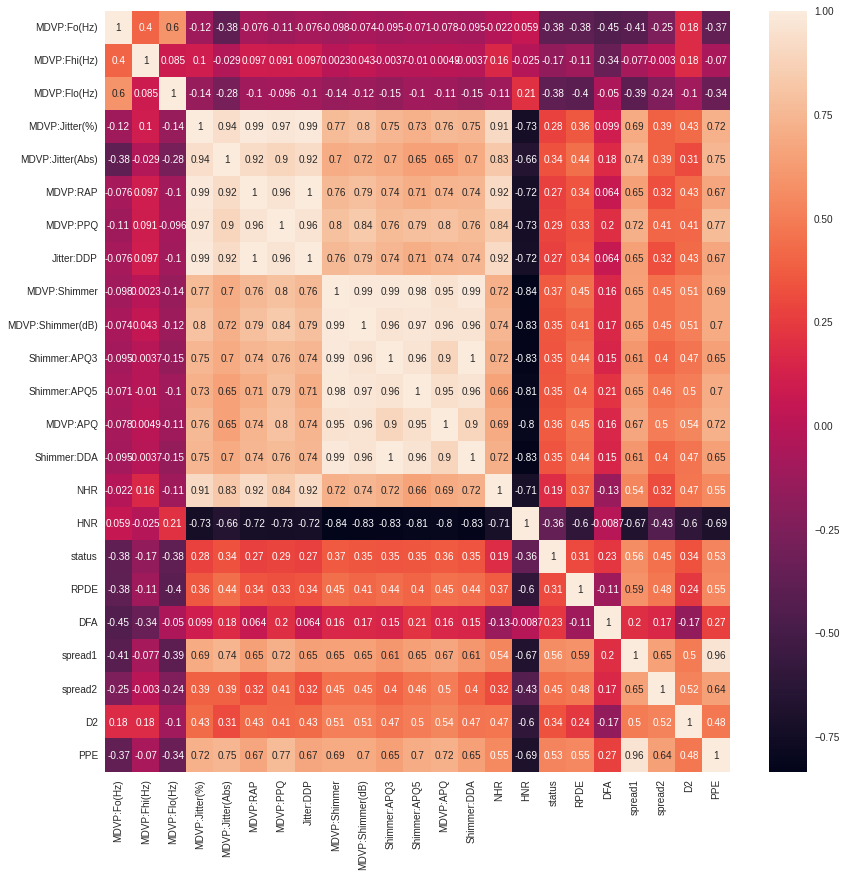

In [25]:
import pandas as pd
import seaborn as sn

nf = 12

f,ax=plt.subplots(figsize=(14,14))

#Create DataFrame and correlation matrix of features
DF =  pd.DataFrame(DS[:,1:].astype(float))
corr_matrix = DF.corr()

sn.heatmap(corr_matrix,annot = True, xticklabels= DS_columns[1:], yticklabels=DS_columns[1:])
plt.show()

**Get Data from Selected Features**

In [26]:
#Function separates data into predictors and responses based on list of 
#features to use provided as an input
def select_data(selected_features,data):
  to_keep = []
  for i in selected_features:
    to_keep.append(DS_feat[i])
  return data[:, to_keep], data[:,status_idx]

**Format Data-Set for Training and Validation**

In [27]:
#Create list of names of all features (Excluding name and status/response)
all_features = list(DS_columns)
all_features.remove('status')
all_features.remove('name')

#Separate data into predictors and responses
data_tt, labels_tt = select_data(all_features, np.vstack(stt_pat_dict[1]))
data_ft, labels_ft = select_data(all_features, np.vstack(stt_pat_dict[0]))
all_predictors = np.concatenate((data_tt, data_ft), axis=0)
all_responses = np.concatenate((labels_tt, labels_ft), axis=0).reshape(-1,1).astype(int)

#Reshape and cast
all_responses = all_responses.reshape(-1,1).astype(int)

#Count number of data points from healthy and sick patients
num_zeros, num_ones = np.unique(all_responses, return_counts=True)[1]


**Cross-Validation Score Function**

In [28]:
#Function calculates the mean of multiple scores of CV processes for a model
def mean_scores_CV(clf):
  mean_scores = []
  for i in range(20):
    scores = cross_val_score(clf, all_predictors,all_responses.transpose()[0], cv=K)
    mean_scores.append(scores.mean())
  return np.array(mean_scores).mean()

**Initialize Feature Selectors**

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

K = 20
print("Number of folds used in Cross-valitation:", K, "\n")


clf = RandomForestClassifier(class_weight={0: num_ones, 1: num_zeros},n_estimators = 4)
print("Average CV Score for Random Forest: ", mean_scores_CV(clf), "\n")

clf = svm.SVC(class_weight={0: num_ones, 1: num_zeros}, kernel='linear', C=1)
print("Average CV Score for Suport Vector Machine: ", mean_scores_CV(clf), "\n")

clf = LogisticRegression(max_iter=200,class_weight={0: num_ones, 1: num_zeros})
print("Average CV Score for Logistic Regression: ", mean_scores_CV(clf), "\n")

clf = DecisionTreeClassifier(class_weight={0: num_ones, 1: num_zeros})
print("Average CV Score for Decision Tree: ", mean_scores_CV(clf), "\n")

Number of folds used in Cross-valitation: 20 

Average CV Score for Random Forest:  0.8272777777777778 

Average CV Score for Suport Vector Machine:  0.753888888888889 

Average CV Score for Logistic Regression:  0.7650000000000001 

Average CV Score for Decision Tree:  0.8204166666666668 



**Get Predictors for Specific Patient**

In [30]:
#Function returns predictors of data points a specific patient
def get_data_pat_list(data, n):
  data_out = []
  for i in range(len(data[n])):
    left = data[n][i][1:DS_feat['status']]
    right = data[n][i][DS_feat['status']+1:]
    full = np.concatenate((left, right), axis=0)
    data_out.append(full)
    return data_out[0]

**Define Cross Validation Structure**

In [31]:
#Function performs cross validation for a given model separating each fold as a 
# set of data points from one healthy patient and one sick patient
def cross_val_scores_patient(clf):
  mean_scores = []
  for n_CV in range(20):
    data_healthy = stt_pat_dict[0]
    data_PD = stt_pat_dict[1]
    scores = []

    #Loop separates one pair of patients from the rest to perform CV
    for n_pat in range(len(stt_pat_dict[0])):
      #Create specified model
      if clf == DecisionTreeClassifier:
        new_clf = DecisionTreeClassifier()
      elif clf == LogisticRegression:
        new_clf = LogisticRegression(max_iter=200)
      elif clf == svm.SVC:
        new_clf = svm.SVC(kernel='linear', C=1)
      elif clf == RandomForestClassifier:
        new_clf = RandomForestClassifier(n_estimators = 4)

      #Create custom test subset
      data_test = [np.array(get_data_pat_list(data_healthy, n_pat), dtype=float)]
      data_test.append(np.array(get_data_pat_list(data_PD, n_pat), dtype=float))
      labels_test = [[0], [1]]

      #Create custom training subset
      data_train = []
      labels_train = []
      for index in range(len(stt_pat_dict[0])):
        if index != n_pat:
          data_train.append(np.array(get_data_pat_list(data_healthy, index), dtype=float))
          labels_train.append(0)
          data_train.append(np.array(get_data_pat_list(data_PD, index), dtype=float))
          labels_train.append(1)
      
      #Fit model
      new_clf.fit(data_train,labels_train)

      #Predict the response for test dataset
      labels_pred = new_clf.predict(data_test)

      bacc = balanced_accuracy_score(labels_test, labels_pred)
      scores.append(bacc)
    mean_scores.append(np.array(scores).mean())
  return np.array(mean_scores).mean()

**Display Cross Validation Results**

In [32]:
from sklearn.metrics import balanced_accuracy_score

print("Cross validation results for Decision tree")
print(cross_val_scores_patient(DecisionTreeClassifier))

print("Cross validation results for Logistic Regression")
print(cross_val_scores_patient(LogisticRegression))

print("Cross validation results for SVM")
print(cross_val_scores_patient(svm.SVC))

print("Cross validation results for Random Forest")
print(cross_val_scores_patient(RandomForestClassifier))

Cross validation results for Decision tree
0.65625
Cross validation results for Logistic Regression
0.625
Cross validation results for SVM
0.625
Cross validation results for Random Forest
0.659375


**Define RFE**

In [33]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X = DF.drop(16 , axis=1)
X_norm = (X - X.min()) / (X.max() - X.min())
y = DF[16]

def select_rfe(nf):
  rfe = RFE(estimator=LogisticRegression(), n_features_to_select=nf)
  rfe = rfe.fit(X_norm, y)
  selected_features_rfe = X.columns[rfe.support_].tolist()
  selected_features_rfe = DS_columns[1:][selected_features_rfe]
  selected_features_rfe = selected_features_rfe.tolist()
  if 'status' in selected_features_rfe:
    selected_features_rfe.remove('status')
  return selected_features_rfe

**Define RFI**

In [34]:
from sklearn.ensemble import RandomForestClassifier

def select_rfi(nf):
  clf = RandomForestClassifier(random_state=0)
  clf.fit(X_norm, y)
  importances = clf.feature_importances_
  feature_importances = pd.DataFrame({"feature": X.columns, "importance": importances})
  feature_importances.sort_values(by="importance", ascending=False, inplace=True)
  top_nf_features = feature_importances.head(nf)
  selected_features_rfc = top_nf_features['feature'].tolist()
  selected_features_rfc = DS_columns[1:][selected_features_rfc]
  selected_features_rfc = selected_features_rfc.tolist()
  if 'status' in selected_features_rfc:
    selected_features_rfc.remove('status')
  return selected_features_rfc

**Define Lasso**

In [35]:
from sklearn.linear_model import Lasso

def select_lasso(nf):
  lasso = Lasso(alpha=0.1)
  lasso.fit(X, y)
  coefs = lasso.coef_

  # Create a dataframe with features and their corresponding coefficients
  feature_coefs = pd.DataFrame({'feature': X.columns, 'coef': coefs})

  # Sort the dataframe by coefficient in descending order
  feature_coefs = feature_coefs.sort_values(by='coef', ascending=False)

  # Get the top 10 features
  top_nf_features = feature_coefs.head(nf)

  # Extract the feature names
  selected_features_lasso = top_nf_features['feature'].tolist()
  selected_features_lasso = DS_columns[1:][selected_features_lasso]
  selected_features_lasso = selected_features_lasso.tolist()

  if 'status' in selected_features_lasso:
    selected_features_lasso.remove('status')
  return selected_features_lasso

**Define PCA**

In [36]:
import pandas as pd
from sklearn.decomposition import PCA

def select_pca(nf):
  pca = PCA(n_components=nf)
  X_pca = pca.fit_transform(X)
  selected_features_pca = pca.components_[0].argsort()[::-1][:nf]
  for i in range(len(selected_features_pca)):
    if selected_features_pca[i] >= 16:
      selected_features_pca[i] += 1
  selected_features_pca = DS_columns[1:][selected_features_pca]
  selected_features_pca = selected_features_pca.tolist()

  return selected_features_pca

**Import Classifiers**

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

**Split into train and testing (testing has 2 positive and two negative patients) in case of patient split**

In [38]:
true = stt_pat_dict[1]
false = stt_pat_dict[0]

true_testing = true[-2:]
false_testing = false[-2:]
true_training = true[:-2]
false_training = false[:-2]

true_testing = np.vstack(true_testing)
false_testing = np.vstack(false_testing)
true_training = np.vstack(true_training)
false_training = np.vstack(false_training)

**Compare Feature Selectors and Classifiers**

In [57]:
from sklearn.model_selection import train_test_split

class predictor():
  def __init__(self):
    self.results = []
    self.selector_names = ('RFE', 'RFI', 'Lasso', 'PCA')
    self.classifier_names = ('Decision-Tree', 'Random-Forest', 'KNN', 'SVM', 'Logistic-Regression')

  def get_tt(self, selected_features):
    """Comment out whether you want to split data-set based on patients or randomly"""

    ### PATIENT
    data_tt, labels_tt = select_data(selected_features, true_testing)
    data_ft, labels_ft = select_data(selected_features, false_testing)
    data_test = np.concatenate((data_tt, data_ft), axis=0)
    labels_test = np.concatenate((labels_tt, labels_ft), axis=0).reshape(-1,1).astype(int)

    data_tt, labels_tt = select_data(selected_features, true_training)
    data_ft, labels_ft = select_data(selected_features, false_training)
    data_train = np.concatenate((data_tt, data_ft), axis=0)
    labels_train = np.concatenate((labels_tt, labels_ft), axis=0).reshape(-1,1).astype(int)

    ### RANDOM
    # split_data, split_labels = select_data(selected_features, DS)
    # data_train, data_test, labels_train, labels_test = train_test_split(split_data, split_labels, test_size = 0.2)

    labels_train = labels_train.reshape(-1,1).astype(int)
    labels_test = labels_test.reshape(-1,1).astype(int)

    return data_train, labels_train, data_test, labels_test

  def select_classify(self):
    self.results = []

    i = 0

    for selector in self.selector_names:
      j=0

      for classifier_name in self.classifier_names:

        if selector == 'RFE':
          if classifier_name == 'Decision-Tree':
            rfe = RFE(estimator = DecisionTreeClassifier(), n_features_to_select=nf)
          elif classifier_name == 'Random-Forest':
            rfe = RFE(estimator = RandomForestClassifier(), n_features_to_select=nf)
          elif classifier_name == 'Logistic-Regression':
            rfe = RFE(estimator = LogisticRegression(), n_features_to_select=nf)
          elif classifier_name == 'SVM':
            rfe = RFE(estimator=LogisticRegression(), n_features_to_select=nf)
          elif classifier_name == 'KNN':
            rfe = RFE(estimator=LogisticRegression(), n_features_to_select=nf)
        
          rfe = rfe.fit(X_norm, y)

          selected_features_rfe = X.columns[rfe.support_].tolist()
          selected_features_rfe = DS_columns[1:][selected_features_rfe]
          selected_features  = selected_features_rfe.tolist()
        elif selector == 'RFI':
          selected_features = select_rfi(nf)
        elif selector == 'Lasso':
          selected_features = select_lasso(nf)
        elif selector == 'PCA':
          selected_features = select_pca(nf)

        data_train, labels_train, data_test, labels_test = self.get_tt(selected_features)

        num_zeros, num_ones = np.unique(labels_train, return_counts=True)[1]
        num_total = num_zeros+num_ones

        #Soft Adaptation
        beta = -1.5
        dist = np.array([num_zeros/num_total, num_ones/num_total])
        weights = np.exp(beta*dist)/sum(np.exp(beta*dist))

        if classifier_name == 'Decision-Tree':
          classifier = DecisionTreeClassifier(class_weight={0: weights[0], 1: weights[1]})
        elif classifier_name == 'Random-Forest':
          classifier = RandomForestClassifier(class_weight={0: weights[0], 1: weights[1]},n_estimators = 4)
        elif classifier_name == 'Logistic-Regression':
          classifier = LogisticRegression(max_iter=200,class_weight={0: weights[0], 1: weights[1]})
        elif classifier_name == 'SVM':
          classifier = SVC(class_weight={0: weights[0], 1: weights[1]}, kernel='linear', C=1)
        elif classifier_name == 'KNN':
          classifier = KNeighborsClassifier(n_neighbors=1)

        classifier.fit(data_train,labels_train.reshape(-1))
        labels_pred_bin = classifier.predict(data_test)
        bacc = balanced_accuracy_score(labels_test, labels_pred_bin)

        self.results.append( [str(nf), self.selector_names[i], self.classifier_names[j], str(round(bacc.item(),5)) ])

        j+=1
      i+=1

    return self.results


import os

if os.path.exists("results.txt"):
  os.remove("results.txt")

file = open("results.txt", "a")

my_predictor = predictor()
nf_prime = 22
for n in range(nf_prime):
  nf = n+1
  results = my_predictor.select_classify()
  for line in results:
    file.write(','.join(line)+'\n')

**Post-Processing of Results**

In [58]:
selector_names = ('RFE', 'RFI', 'Lasso', 'PCA')
classifier_names = ('Decision-Tree', 'Random-Forest', 'Logistic-Regression', 'SVM', 'KNN')

file.close()
file = open('results.txt', "r")

data = [line.replace('\n', '').split(',') for line in file]

dt = {}
for selector in selector_names: dt[selector] = []
rf = {}
for selector in selector_names: rf[selector] = []
lr = {}
for selector in selector_names: lr[selector] = []
svm = {}
for selector in selector_names: svm[selector] = []
knn = {}
for selector in selector_names: knn[selector] = []

for line in data:
  if line[2] == 'Decision-Tree':
    dt[line[1]].append([float(line[0]),float(line[3])])
  elif line[2] == 'Random-Forest':
    rf[line[1]].append([float(line[0]),float(line[3])])
  elif line[2] == 'Logistic-Regression':
    lr[line[1]].append([float(line[0]),float(line[3])])
  elif line[2] == 'SVM':
    svm[line[1]].append([float(line[0]),float(line[3])])
  elif line[2] == 'KNN':
    knn[line[1]].append([float(line[0]),float(line[3])])

for selector in selector_names: dt[selector] = np.array(dt[selector])
for selector in selector_names: rf[selector] = np.array(rf[selector])
for selector in selector_names: lr[selector] = np.array(lr[selector])
for selector in selector_names: svm[selector] = np.array(svm[selector])
for selector in selector_names: knn[selector] = np.array(knn[selector])

**Plot Decision-Tree Results**

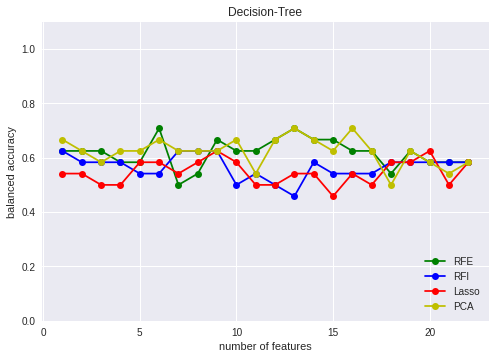

In [59]:
plt.style.use('seaborn')
plt.plot(dt['RFE'][:,0], dt['RFE'][:,1], '-o',color='g')
plt.plot(dt['RFI'][:,0], dt['RFI'][:,1], '-o',color='b')
plt.plot(dt['Lasso'][:,0], dt['Lasso'][:,1], '-o',color='r')
plt.plot(dt['PCA'][:,0], dt['PCA'][:,1], '-o',color='y')
	
plt.xlabel('number of features') 
plt.ylabel('balanced accuracy')
plt.ylim([0, 1.1])
plt.legend(['RFE', 'RFI', 'Lasso', 'PCA'], loc ="lower right")
plt.title('Decision-Tree')
plt.savefig("Decision-Tree_div_patients.png")
plt.show()

**Plot Random-Forest Results**

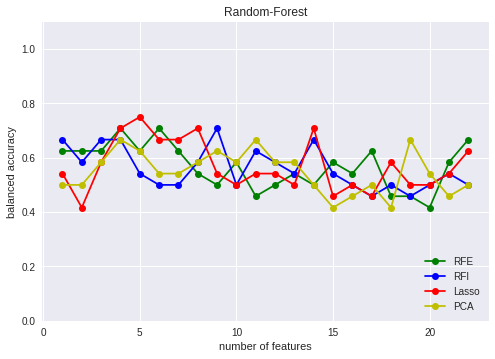

In [60]:
plt.style.use('seaborn')
plt.plot(rf['RFE'][:,0], rf['RFE'][:,1], '-o',color='g')
plt.plot(rf['RFI'][:,0], rf['RFI'][:,1], '-o',color='b')
plt.plot(rf['Lasso'][:,0], rf['Lasso'][:,1], '-o',color='r')
plt.plot(rf['PCA'][:,0], rf['PCA'][:,1], '-o',color='y')
	
plt.xlabel('number of features') 
plt.ylabel('balanced accuracy')
plt.ylim([0, 1.1])
plt.legend(['RFE', 'RFI', 'Lasso', 'PCA'], loc ="lower right")
plt.title('Random-Forest')
plt.savefig("Random-Forest_div_patients.png")
plt.show()

**Plot Logistic-Regression Results**

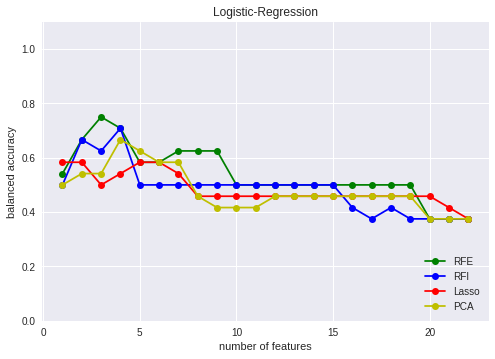

In [61]:
plt.style.use('seaborn')
plt.plot(lr['RFE'][:,0], lr['RFE'][:,1], '-o',color='g')
plt.plot(lr['RFI'][:,0], lr['RFI'][:,1], '-o',color='b')
plt.plot(lr['Lasso'][:,0], lr['Lasso'][:,1], '-o',color='r')
plt.plot(lr['PCA'][:,0], lr['PCA'][:,1], '-o',color='y')
	
plt.xlabel('number of features') 
plt.ylabel('balanced accuracy')
plt.ylim([0, 1.1])
plt.legend(['RFE', 'RFI', 'Lasso', 'PCA'], loc ="lower right")
plt.title('Logistic-Regression')
plt.savefig("Logistic-Regression_div_patients.png")
plt.show()

**Plot Support-Vector-Machine Results**

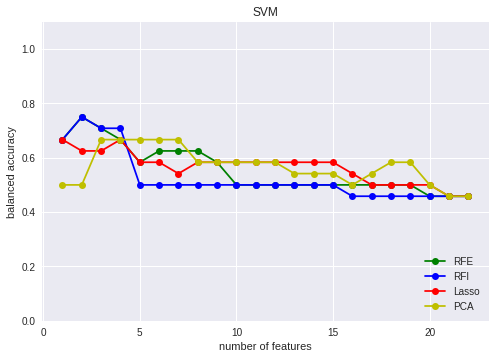

In [62]:
plt.style.use('seaborn')
plt.plot(svm['RFE'][:,0], svm['RFE'][:,1], '-o',color='g')
plt.plot(svm['RFI'][:,0], svm['RFI'][:,1], '-o',color='b')
plt.plot(svm['Lasso'][:,0], svm['Lasso'][:,1], '-o',color='r')
plt.plot(svm['PCA'][:,0], svm['PCA'][:,1], '-o',color='y')
plt.xlabel('number of features') 
plt.ylabel('balanced accuracy')
plt.ylim([0, 1.1])
plt.legend(['RFE', 'RFI', 'Lasso', 'PCA'], loc ="lower right")
plt.title('SVM')
plt.savefig("SVM_div_patients.png")
plt.show()

**Proposed Model Evaluation**

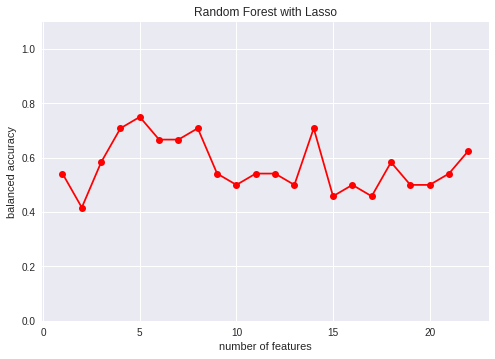

Number of Features Selected:  4.0, 5.0, 6.0, 7.0
Balanced Accuracy:  0.70833, 0.75, 0.66667, 0.66667


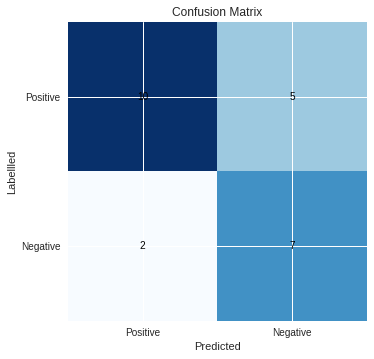

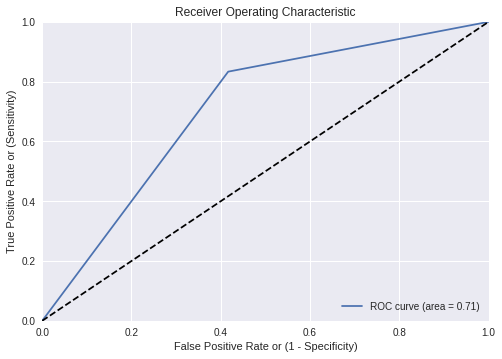

BACC:  0.642
AUC:  0.708
Sensitivity:  0.833
Specificity:  0.583


In [172]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

#Plot Decision-Tree
plt.style.use('seaborn')
plt.plot(rf['Lasso'][:,0], rf['Lasso'][:,1], '-o',color='r')
	
plt.xlabel('number of features') 
plt.ylabel('balanced accuracy')
plt.ylim([0, 1.1])
plt.title('Random Forest with Lasso')
plt.savefig("RF-Lasso.png")
plt.show()

#Print Balanced Accuracy
print('Number of Features Selected: ', ', '.join(map(str, rf['Lasso'][3:7,0])))  
print('Balanced Accuracy: ', ', '.join(map(str, rf['Lasso'][3:7,1]))) 

#Select Features and Split into Training and Testing
selected_features = select_lasso(5)
data_train, labels_train, data_test, labels_test = my_predictor.get_tt(selected_features)
num_zeros, num_ones = np.unique(labels_train, return_counts=True)[1]
num_total = num_zeros+num_ones

#Soft Adaptation
beta = -2
dist = np.array([num_zeros/num_total, num_ones/num_total])
weights = np.exp(beta*dist)/sum(np.exp(beta*dist))

#Classify
bacc_list = []
classifier = RandomForestClassifier(class_weight={0: weights[0], 1: weights[1]},n_estimators = 4)
for _ in range(5):
  for j in range(4,7):
    #Select Features and Split into Training and Testing
    selected_features = select_lasso(j)
    data_train, labels_train, data_test, labels_test = my_predictor.get_tt(selected_features)
    num_zeros, num_ones = np.unique(labels_train, return_counts=True)[1]
    num_total = num_zeros+num_ones

    #Soft Adaptation
    beta = -5
    dist = np.array([num_zeros/num_total, num_ones/num_total])
    weights = np.exp(beta*dist)/sum(np.exp(beta*dist))

    classifier.fit(data_train,labels_train.reshape(-1))
    labels_pred_bin = classifier.predict(data_test)
    bacc = balanced_accuracy_score(labels_test, labels_pred_bin)
    bacc_list.append(bacc)

#Confusion Matrix
tn, fp, fn, tp = confusion_matrix(labels_test, labels_pred_bin).ravel()
confusion_matrix = np.array([[tp, fp], [fn, tn]])

plt.imshow(confusion_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Labellled')
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])

for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='black')

plt.savefig("ConfMatrix.png")
plt.show()

#Metric
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
labels_pred = classifier.predict(data_test)
auc = roc_auc_score(labels_test, labels_pred)
fpr, tpr, thresholds = roc_curve(labels_test, labels_pred)

#ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specificity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("ROC.png")
plt.show()

print('BACC: ', round(sum(bacc_list) / len(bacc_list),3))
print("AUC: ", round(auc,3))
print('Sensitivity: ', round(sensitivity,3))
print('Specificity: ', round(specificity,3))